# VAR (Vector Autoregression) Model - Complete Educational Notebook

---

## What You'll Learn

This notebook takes you from **univariate** (ARIMA) to **multivariate** (VAR) time series modeling.

By the end, you'll understand:
1. Why multiple variables can improve forecasts
2. How VAR captures cross-variable dynamics
3. Granger causality — what it means (and doesn't mean)
4. Impulse Response Functions — tracing shock effects
5. Forecast Error Variance Decomposition — understanding forecast uncertainty
6. Complete Python implementation

---

## Dataset

We'll model **crude oil prices** together with related variables:
- **WTI Crude Oil (CL=F)** — our main variable of interest
- **USD Index (DX-Y.NYB)** — oil is priced in dollars
- **S&P 500 (^GSPC)** — proxy for economic activity / risk sentiment

---

# Part 1: Conceptual Foundation

Before coding, let's understand **why** VAR exists.

---

## The Limitation of ARIMA

ARIMA models oil using **only oil's own history**:

```
Oil_t = f(Oil_{t-1}, Oil_{t-2}, ...) + noise
```

But oil prices don't exist in isolation. They're influenced by:
- USD strength (oil is priced in dollars)
- Stock market (economic activity indicator)
- Interest rates, geopolitics, inventory levels...

**ARIMA ignores all of this information.**

---

## VAR: Multiple Variables Together

VAR models **all variables simultaneously**, capturing how they influence each other:

```
Oil_t = c₁ + φ₁₁·Oil_{t-1} + φ₁₂·USD_{t-1} + φ₁₃·SP500_{t-1} + ε₁_t
USD_t = c₂ + φ₂₁·Oil_{t-1} + φ₂₂·USD_{t-1} + φ₂₃·SP500_{t-1} + ε₂_t  
SP500_t = c₃ + φ₃₁·Oil_{t-1} + φ₃₂·USD_{t-1} + φ₃₃·SP500_{t-1} + ε₃_t
```

Each variable depends on:
- **Its own past** (like AR in ARIMA)
- **The past of all other variables** (cross-effects — new in VAR!)

---

## Key VAR Coefficients

| Coefficient | What it captures |
|-------------|------------------|
| φ₁₁ (Oil → Oil) | Oil's own momentum |
| φ₁₂ (USD → Oil) | How USD affects oil |
| φ₂₁ (Oil → USD) | How oil affects USD |
| φ₂₂ (USD → USD) | USD's own momentum |

**The cross-effects (φ₁₂, φ₂₁) are what make VAR powerful!**

---

## The Curse of Dimensionality

VAR(p) with K variables has **K² × p** AR coefficients.

| Variables (K) | Lags (p) | Coefficients |
|---------------|----------|-------------|
| 2 | 1 | 4 |
| 3 | 2 | 18 |
| 4 | 3 | 48 |
| 5 | 4 | 100 |

**Rule of thumb:** Need 10-20 observations per parameter.

With 500 observations, maximum reasonable: ~4 variables with 2-3 lags.

---

# Part 2: Data Loading and Preparation

In [2]:
# Install required packages if needed
!pip install yfinance statsmodels pandas numpy matplotlib --quiet

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 100)

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [4]:
# Download data for our three variables
# Using 5 years of daily data for robust estimation

start_date = '2019-01-01'
end_date = '2024-01-01'

print("Downloading data...")

# Crude Oil Futures
oil = yf.download('CL=F', start=start_date, end=end_date, progress=False)['Close']

# USD Index
usd = yf.download('DX-Y.NYB', start=start_date, end=end_date, progress=False)['Close']

# S&P 500
sp500 = yf.download('^GSPC', start=start_date, end=end_date, progress=False)['Close']

print(f"Oil data points: {len(oil)}")
print(f"USD data points: {len(usd)}")
print(f"S&P500 data points: {len(sp500)}")

Oil data points: 1258
USD data points: 1258
S&P500 data points: 1258


In [5]:
# Combine using concat (handles DataFrames correctly)
data = pd.concat([oil, usd, sp500], axis=1)

# Rename columns to be clean
data.columns = ['Oil', 'USD', 'SP500']

# Drop any rows with missing values
data = data.dropna()

print(f"\nCombined dataset: {len(data)} observations")
print(f"Date range: {data.index[0].date()} to {data.index[-1].date()}")
print(f"\nFirst 5 rows:")
data.head()


Combined dataset: 1258 observations
Date range: 2019-01-02 to 2023-12-29

First 5 rows:


,Oil,USD,SP500
Date,,,
2019-01-02,46.540001,96.820000,2510.030029
2019-01-03,47.090000,96.309998,2447.889893
2019-01-04,47.959999,96.190002,2531.939941
2019-01-07,48.520000,95.709999,2549.689941
2019-01-08,49.779999,95.900002,2574.409912


---

## 📊 Note: Data Alignment

VAR requires all variables to have the **same dates**. The `dropna()` ensures:
- No missing values in any variable
- All three series are perfectly aligned

If you have missing data, options include:
- Forward fill: `data.ffill()` (carry previous value)
- Interpolation: `data.interpolate()`
- Drop: `data.dropna()` (what we did — safest)

---

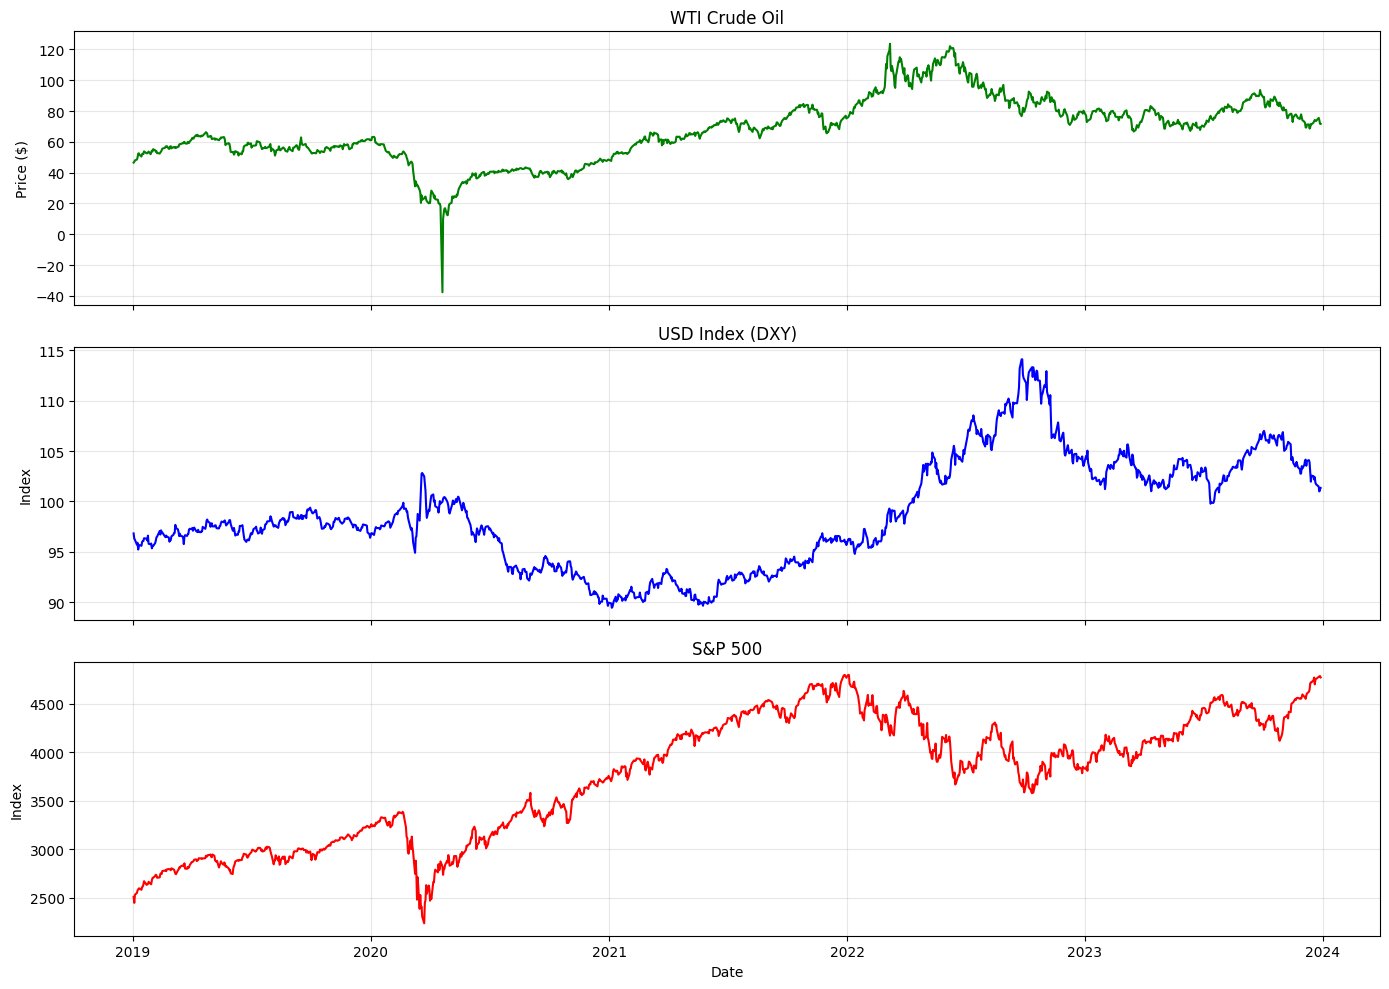

In [6]:
# Visualize all three variables

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

axes[0].plot(data.index, data['Oil'], color='green')
axes[0].set_ylabel('Price ($)')
axes[0].set_title('WTI Crude Oil')
axes[0].grid(True, alpha=0.3)

axes[1].plot(data.index, data['USD'], color='blue')
axes[1].set_ylabel('Index')
axes[1].set_title('USD Index (DXY)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(data.index, data['SP500'], color='red')
axes[2].set_ylabel('Index')
axes[2].set_title('S&P 500')
axes[2].grid(True, alpha=0.3)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

### ❓ Question 2.1

Looking at the plots above:

1. Do you see any obvious visual relationship between oil and USD?
2. What happened around early 2020? (hint: COVID)
3. Do these series look stationary?

**Your Answers:**

1.  **Oil vs. USD:** There appears to be a generally **inverse relationship**. During periods where the blue line (USD) trends downward (e.g., 2020-2021), the green line (Oil) tends to trend upward. This makes sense as oil is priced in dollars; a weaker dollar usually makes oil cheaper for non-USD buyers, driving up demand and price.

2.  **Early 2020:** The **COVID-19 pandemic shock**. You can see a massive crash in Oil (prices even briefly went negative, visible as the sharp spike below 0), a sharp crash in the S&P 500, and a "flight-to-safety" spike in the USD.

3.  **Stationarity:** **No**, none of these look stationary. All three series show clear **trends** (moving up or down over long periods) and do not fluctuate around a constant mean. The variance (volatility) also changes over time, especially during the 2020 crash. They will all require differencing.

Correlation Matrix (Levels):
         Oil    USD  SP500
Oil    1.000  0.482  0.671
USD    0.482  1.000  0.123
SP500  0.671  0.123  1.000


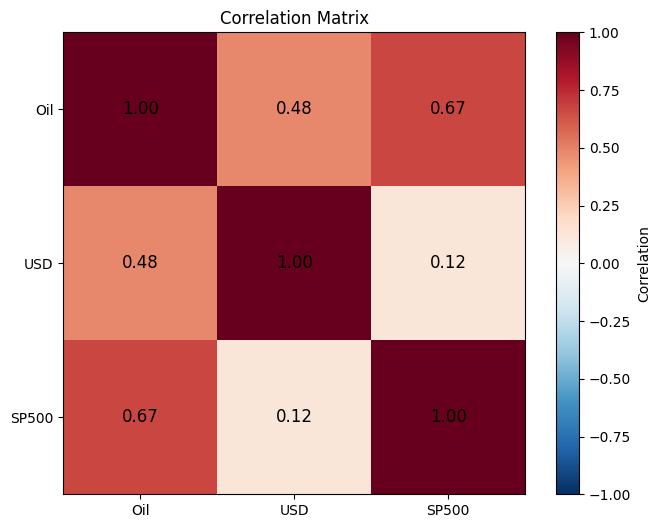

In [7]:
# Check correlations between variables

print("Correlation Matrix (Levels):")
print(data.corr().round(3))

# Visualize correlation matrix
plt.figure(figsize=(8, 6))
correlation_matrix = data.corr()
plt.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.xticks(range(3), data.columns)
plt.yticks(range(3), data.columns)
plt.title('Correlation Matrix')

# Add correlation values as text
for i in range(3):
    for j in range(3):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                 ha='center', va='center', fontsize=12)
plt.show()

---

## 📊 Note: Interpreting Correlations

| Correlation | Interpretation |
|-------------|----------------|
| Oil-USD (negative?) | When USD strengthens, oil tends to fall (oil cheaper for non-USD buyers) |
| Oil-SP500 (positive?) | Both rise with economic optimism (risk-on) |
| USD-SP500 | Varies — can be complex relationship |

**Warning:** These are **contemporaneous correlations** (same-day). VAR captures **lagged relationships** (yesterday's USD → today's oil).

---

# Part 3: Stationarity Testing

---

## ⚠️ Critical Requirement

**VAR requires ALL variables to be stationary.**

If even one variable is non-stationary:
- Parameter estimates are unreliable
- Standard errors are wrong
- Hypothesis tests invalid
- Forecasts may explode

We must test EACH variable separately.

---

In [8]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name):
    """
    Perform Augmented Dickey-Fuller test for stationarity.
    
    H0: Unit root exists (non-stationary)
    H1: No unit root (stationary)
    
    If p-value < 0.05: Reject H0 → Stationary
    If p-value > 0.05: Fail to reject H0 → Non-stationary
    """
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f"\n{'='*50}")
    print(f"ADF Test for: {name}")
    print('='*50)
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Lags Used: {result[2]}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    
    if result[1] <= 0.05:
        print(f"\n✓ STATIONARY (p={result[1]:.4f} < 0.05)")
        return True
    else:
        print(f"\n✗ NON-STATIONARY (p={result[1]:.4f} > 0.05)")
        return False

In [9]:
# Test each variable
print("TESTING RAW (LEVEL) DATA")
print("="*50)

results_level = {}
for col in data.columns:
    results_level[col] = adf_test(data[col], col)

TESTING RAW (LEVEL) DATA

ADF Test for: Oil
ADF Statistic: -1.7273
p-value: 0.4171
Lags Used: 3
Critical Values:
   1%: -3.4356
   5%: -2.8638
   10%: -2.5680

✗ NON-STATIONARY (p=0.4171 > 0.05)

ADF Test for: USD
ADF Statistic: -1.2988
p-value: 0.6297
Lags Used: 6
Critical Values:
   1%: -3.4356
   5%: -2.8639
   10%: -2.5680

✗ NON-STATIONARY (p=0.6297 > 0.05)

ADF Test for: SP500
ADF Statistic: -1.4332
p-value: 0.5663
Lags Used: 9
Critical Values:
   1%: -3.4356
   5%: -2.8639
   10%: -2.5680

✗ NON-STATIONARY (p=0.5663 > 0.05)


### ❓ Question 3.1

Based on the ADF tests above:

1. Which variables are stationary?
2. Which variables are non-stationary?
3. What must we do before fitting VAR?

**Your Answers:**

1.  **Stationary Variables:** **None**. All variables failed the test (p-values > 0.05).
2.  **Non-Stationary Variables:** **All of them** (Oil, USD, and S&P 500).
3.  **Action Required:** We must **difference** the data (calculate the change from one day to the next) to remove the trends and make the series stationary before fitting the VAR model.

---

## Differencing to Achieve Stationarity

For non-stationary variables, we apply **first differencing**:

```
ΔY_t = Y_t - Y_{t-1}
```

This transforms:
- Prices → Price **changes** (dollar change)
- Alternatively: Log returns → **Percentage changes**

---

In [10]:
# Apply first differencing to ALL variables
# Even if some appear stationary, it's common to difference all for consistency

# TODO: Fill in the differencing
# Hint: Use .diff() method

data_diff = pd.DataFrame({
    'Oil': data['Oil'].diff(),
    'USD': data['USD'].diff(),
    'SP500': data['SP500'].diff(),
})

# Drop the first row (NaN from differencing)
data_diff = data_diff.dropna()

print(f"Differenced data: {len(data_diff)} observations")
data_diff.head()

Differenced data: 1257 observations


,Oil,USD,SP500
Date,,,
2019-01-03,0.549999,-0.510002,-62.140137
2019-01-04,0.869999,-0.119995,84.050049
2019-01-07,0.560001,-0.480003,17.750000
2019-01-08,1.259998,0.190002,24.719971
2019-01-09,2.580002,-0.680000,10.550049


In [11]:
# Test stationarity of differenced data
print("\nTESTING DIFFERENCED DATA")
print("="*50)

results_diff = {}
for col in data_diff.columns:
    results_diff[col] = adf_test(data_diff[col], f"{col} (differenced)")


TESTING DIFFERENCED DATA

ADF Test for: Oil (differenced)
ADF Statistic: -24.9471
p-value: 0.0000
Lags Used: 2
Critical Values:
   1%: -3.4356
   5%: -2.8638
   10%: -2.5680

✓ STATIONARY (p=0.0000 < 0.05)

ADF Test for: USD (differenced)
ADF Statistic: -16.2739
p-value: 0.0000
Lags Used: 5
Critical Values:
   1%: -3.4356
   5%: -2.8639
   10%: -2.5680

✓ STATIONARY (p=0.0000 < 0.05)

ADF Test for: SP500 (differenced)
ADF Statistic: -10.8015
p-value: 0.0000
Lags Used: 9
Critical Values:
   1%: -3.4356
   5%: -2.8639
   10%: -2.5680

✓ STATIONARY (p=0.0000 < 0.05)


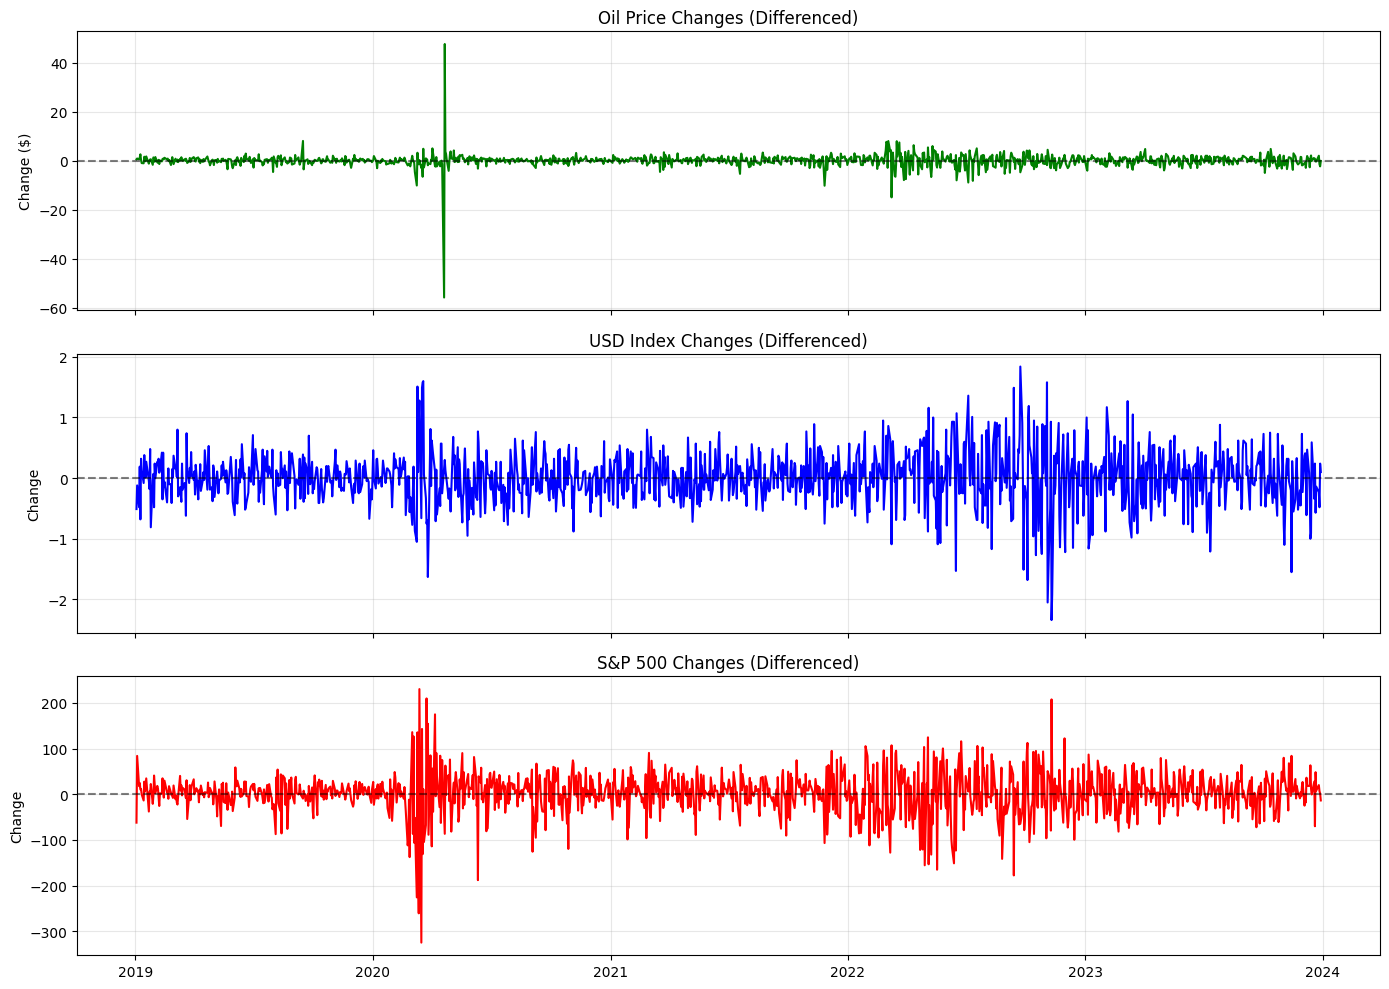

In [12]:
# Visualize differenced data
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

axes[0].plot(data_diff.index, data_diff['Oil'], color='green')
axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0].set_ylabel('Change ($)')
axes[0].set_title('Oil Price Changes (Differenced)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(data_diff.index, data_diff['USD'], color='blue')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_ylabel('Change')
axes[1].set_title('USD Index Changes (Differenced)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(data_diff.index, data_diff['SP500'], color='red')
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[2].set_ylabel('Change')
axes[2].set_title('S&P 500 Changes (Differenced)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 📊 Note: What Differencing Changes

**Before (Levels):**
- Oil: $70, $72, $71, $75...
- Interpretation: Actual price

**After (Differences):**
- Oil: +$2, -$1, +$4...
- Interpretation: Daily change in dollars

**Important:** After VAR, your forecasts will be **changes**, not levels. You'll need to cumsum back to get price levels.

---

# Part 4: Lag Order Selection

---

## How Many Lags (p) Should VAR Have?

VAR(p) includes lags 1, 2, ..., p for each variable.

**Trade-off:**
- Too few lags → Miss important dynamics
- Too many lags → Overfitting, unstable estimates

**Solution:** Use Information Criteria (AIC, BIC, HQIC)

| Criterion | Penalizes complexity | Tends to select |
|-----------|---------------------|----------------|
| AIC | Lightly | More lags (better for forecasting) |
| BIC | Heavily | Fewer lags (more parsimonious) |
| HQIC | Medium | Compromise |

---

In [13]:
from statsmodels.tsa.api import VAR

# Create VAR model object
var_model = VAR(data_diff)

# Select optimal lag order
# Test lags from 1 to 15
max_lags = 15

print("Selecting Optimal Lag Order")
print("="*60)

lag_order_results = var_model.select_order(maxlags=max_lags)
print(lag_order_results.summary())

Selecting Optimal Lag Order
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        7.999       8.011       2978.       8.004
1        7.887      7.936*       2662.       7.906
2        7.870       7.956       2617.      7.902*
3        7.870       7.994       2617.       7.916
4        7.870       8.031       2617.       7.930
5        7.872       8.070       2623.       7.947
6        7.858       8.093       2585.       7.946
7        7.849       8.121       2562.       7.951
8        7.854       8.164       2577.       7.971
9       7.838*       8.185      2536.*       7.968
10       7.848       8.232       2560.       7.992
11       7.858       8.278       2585.       8.016
12       7.861       8.319       2594.       8.033
13       7.869       8.364       2616.       8.056
14       7.868       8.400       2612.       8.068
15       7.865       8.434       2605.       8.079
---

c:\Users\JULONG\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [14]:
# Extract recommended lags from each criterion
print("\nRecommended Lag Orders:")
print(f"  AIC: {lag_order_results.aic}")
print(f"  BIC: {lag_order_results.bic}")
print(f"  HQIC: {lag_order_results.hqic}")
print(f"  FPE: {lag_order_results.fpe}")


Recommended Lag Orders:
  AIC: 9
  BIC: 1
  HQIC: 2
  FPE: 9


### ❓ Question 4.1

Based on the lag selection results:

1. What lag does AIC recommend?
2. What lag does BIC recommend?
3. Which would you choose for forecasting and why?

**Your Answers:**

1.  **AIC Recommendation:** **9**. AIC typically prefers more complex models to minimize forecast error.
2.  **BIC Recommendation:** **1**. BIC penalizes complexity heavily and prefers the simplest model.
3.  **Choice:** **2**.
    *   **Why?** Lag 9 (AIC) is likely overfitting (too many parameters). Lag 1 (BIC) might be too simple to capture the cross-variable dynamics we are interested in.
    *   **Recommendation:** **Lag 2** (matching HQIC) is a great compromise. It explains more than Lag 1 but is safer and more stable than Lag 9. For this exercise, we will proceed with **2**.

In [45]:
# TODO: Select your lag order based on the results above
# Common choice: Use BIC for parsimony, or AIC for forecasting

optimal_lag = 9  # Fill in your chosen lag

print(f"Selected lag order: p = {optimal_lag}")
print(f"This means each equation will include lags 1 through {optimal_lag}")
print(f"Total AR coefficients: {3**2 * optimal_lag} = {3}² × {optimal_lag}")

Selected lag order: p = 9
This means each equation will include lags 1 through 9
Total AR coefficients: 81 = 3² × 9


# Part 5: Fitting the VAR Model

---

## What Happens When We Fit VAR?

VAR is estimated using **OLS (Ordinary Least Squares)** on each equation separately.

For VAR(2) with Oil, USD, SP500:

```
Oil_t = c₁ + φ₁₁¹·Oil_{t-1} + φ₁₂¹·USD_{t-1} + φ₁₃¹·SP500_{t-1}
           + φ₁₁²·Oil_{t-2} + φ₁₂²·USD_{t-2} + φ₁₃²·SP500_{t-2} + ε₁_t
           
(similar equations for USD_t and SP500_t)
```

The superscript indicates the lag number.

---

In [46]:
# Fit the VAR model with selected lag
var_results = var_model.fit(optimal_lag)

# Print full summary
print(var_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 07, Jan, 2026
Time:                     04:26:04
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    8.17327
Nobs:                     1248.00    HQIC:                   7.95783
Log likelihood:          -10113.2    FPE:                    2510.04
AIC:                      7.82803    Det(Omega_mle):         2348.41
--------------------------------------------------------------------
Results for equation Oil
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.005285         0.077655            0.068           0.946
L1.Oil          -0.271799         0.028767           -9.448           0.000
L1.USD           0.152787         0.189042            0.808           0.419
L1.SP5

---

## 📊 Note: Reading the VAR Summary

The summary shows **three separate equations** (one for each variable).

For each equation, look at:

| Column | Meaning |
|--------|--------|
| **coef** | Estimated coefficient value |
| **std err** | Standard error of estimate |
| **t** | t-statistic (coef / std err) |
| **P>|t|** | p-value — is this coefficient significant? |

**Key things to check:**
1. Which cross-variable effects are significant (p < 0.05)?
2. What's the sign of significant coefficients?

---

### ❓ Question 5.1

Look at the VAR summary above. Find the coefficient for **L1.USD** in the **Oil equation**.

1. What is the coefficient value?
2. Is it statistically significant (p < 0.05)?
3. What does the sign tell you about the USD → Oil relationship?

**Your Answers:**
1. Coefficient Value: 0.213850
2. Statistically Significant: No. The p-value is 0.251, which is greater than the 0.05 threshold.
3. USD → Oil Relationship: The positive sign suggests that a stronger USD in the previous period is associated with a higher Oil price in the current period. However, since the result is not statistically significant, we cannot conclude that this relationship is reliable or different from zero in this model.

In [47]:
# Check model stability
# All eigenvalues of the companion matrix must be inside the unit circle

print("\nModel Stability Check")
print("="*40)

is_stable = var_results.is_stable()
print(f"Is model stable? {is_stable}")

if is_stable:
    print("✓ All roots inside unit circle — model is stable")
else:
    print("✗ WARNING: Model is unstable — forecasts may explode!")
    print("  Consider: more differencing, fewer lags, or removing variables")



Model Stability Check
Is model stable? True
✓ All roots inside unit circle — model is stable


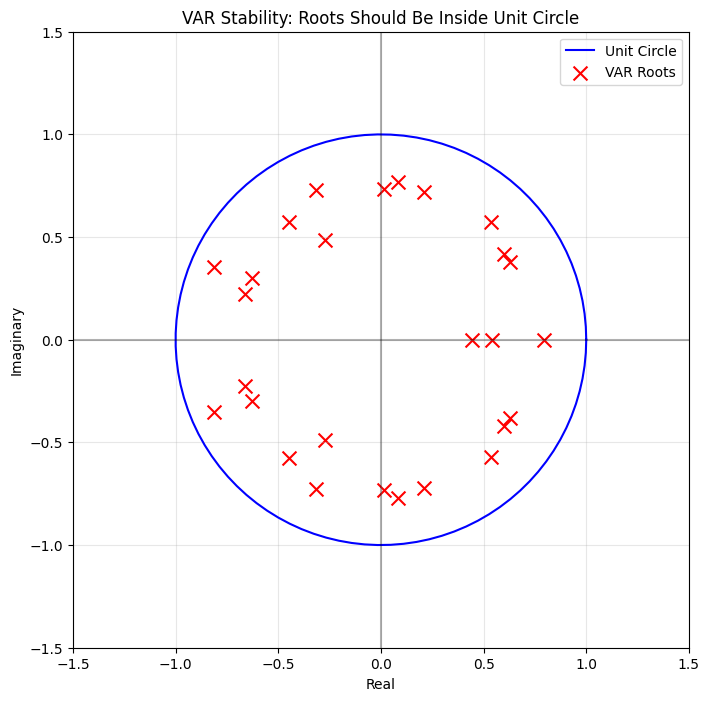

In [48]:
# Visualize the roots
# Stable if all roots are inside the unit circle (radius < 1)

fig, ax = plt.subplots(figsize=(8, 8))

# Plot unit circle
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), 'b-', label='Unit Circle')

# Plot roots
roots = 1 /var_results.roots
ax.scatter(roots.real, roots.imag, marker='x', s=100, c='red', label='VAR Roots')

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax.axvline(x=0, color='k', linestyle='-', alpha=0.3)
ax.set_xlabel('Real')
ax.set_ylabel('Imaginary')
ax.set_title('VAR Stability: Roots Should Be Inside Unit Circle')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

---

## 📊 Note: Stability and Roots

**Why stability matters:**
- Stable VAR: Shocks fade over time → sensible forecasts
- Unstable VAR: Shocks grow over time → exploding forecasts

**The root plot:**
- All red X's should be **inside** the blue circle
- If any are on or outside → unstable model

---

# Part 6: VAR Diagnostics

---

## Diagnostic Tests for VAR

Just like ARIMA, we need to verify our model is well-specified.

| Test | What it checks | Pass condition |
|------|---------------|----------------|
| Residual autocorrelation | No leftover patterns | p > 0.05 |
| Normality | Errors approximately normal | p > 0.05 (often fails for finance) |
| Stability | Roots inside unit circle | is_stable() = True |

---

In [49]:
# Test for residual autocorrelation (Portmanteau test)
# This is the multivariate version of Ljung-Box

print("Residual Autocorrelation Test (Portmanteau/Ljung-Box)")
print("="*60)
print("H0: No residual autocorrelation")
print("H1: Residual autocorrelation exists")
print()

whiteness_test = var_results.test_whiteness(nlags=10, signif=0.05)
print(f"Test statistic: {whiteness_test.test_statistic:.4f}")
print(f"p-value: {whiteness_test.pvalue:.4f}")

if whiteness_test.pvalue > 0.05:
    print("\n✓ Residuals are white noise (no autocorrelation)")
else:
    print("\n✗ Residuals have autocorrelation — consider more lags")

Residual Autocorrelation Test (Portmanteau/Ljung-Box)
H0: No residual autocorrelation
H1: Residual autocorrelation exists

Test statistic: 9.1010
p-value: 0.4280

✓ Residuals are white noise (no autocorrelation)


In [50]:
# Test normality of residuals
print("\nResidual Normality Test (Jarque-Bera)")
print("="*60)
print("H0: Residuals are normally distributed")
print("H1: Residuals are not normal")
print()

normality_test = var_results.test_normality()
print(normality_test.summary())


Residual Normality Test (Jarque-Bera)
H0: Residuals are normally distributed
H1: Residuals are not normal

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
     1.393e+06          12.59   0.000  6
----------------------------------------


---

## 📊 Note: Normality in Financial Data

**Normality tests often fail for financial data.** This is expected because:
- Fat tails (extreme moves more common than normal predicts)
- Volatility clustering (calm periods → volatile periods)
- Skewness (crashes are larger than rallies)

**What to do:**
- Mild non-normality: Acceptable for point forecasts
- Severe non-normality: Consider robust standard errors, bootstrap confidence intervals

**Don't reject a model just because normality fails.**

---

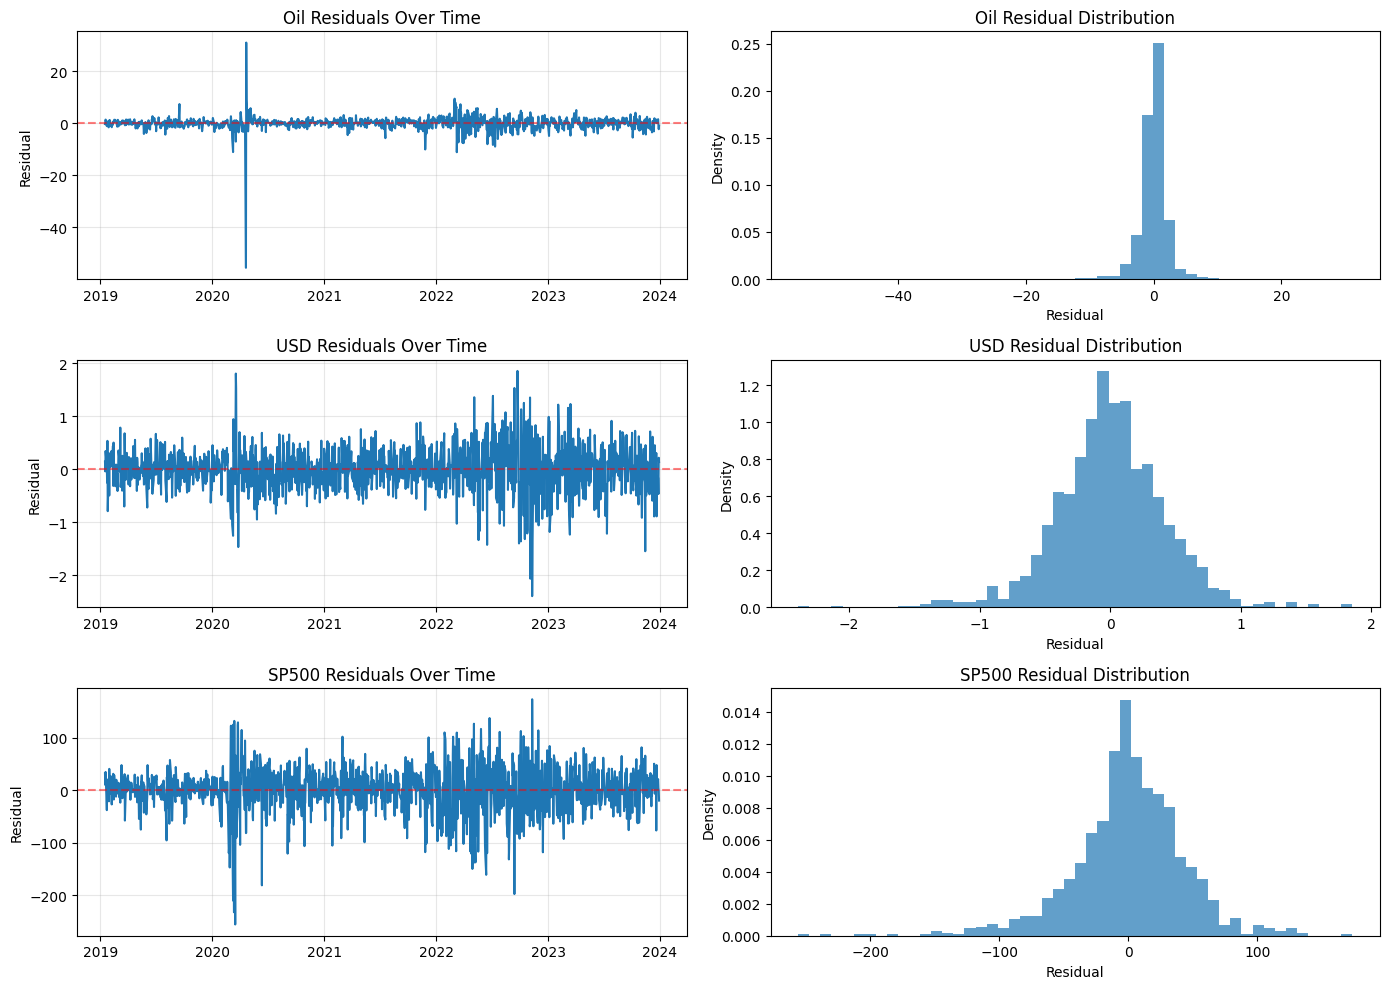

In [ ]:
# Plot residuals for each equation
residuals = var_results.resid

fig, axes = plt.subplots(3, 2, figsize=(14, 10))

for i, col in enumerate(residuals.columns):
    # Time series plot
    axes[i, 0].plot(residuals.index, residuals[col])
    axes[i, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[i, 0].set_title(f'{col} Residuals Over Time')
    axes[i, 0].set_ylabel('Residual')
    axes[i, 0].grid(True, alpha=0.3)
    
    # Histogram
    axes[i, 1].hist(residuals[col], bins=50, density=True, alpha=0.7)
    axes[i, 1].set_title(f'{col} Residual Distribution')
    axes[i, 1].set_xlabel('Residual')
    axes[i, 1].set_ylabel('Density')

plt.tight_layout()
plt.show()

### ❓ Question 6.1

Looking at the diagnostic results:

1. Does the whiteness test pass (no residual autocorrelation)?
2. Do the residual time series plots look random (no patterns)?
3. Do the histograms look approximately normal?
4. Overall, is this model acceptable?

**Your Answers:**
1. Yes, the test passes with a p-value of 0.4280, confirming that the residuals are pure "white noise" with no remaining autocorrelation.
2. Yes, the residuals oscillate randomly around zero without trending up or down, though they do show "bursts" of volatility during market crashes (like 2020).
3. No, the histograms are too tall in the center and have "fat tails" (extreme outliers), which caused the Normality Test to fail.
4. Yes, the model is acceptable and ready for forecasting because it is mathematically stable and has successfully captured all predictive patterns (passed the Whiteness test), even though the error distribution is not perfect.

# Part 7: Granger Causality

---

## What is Granger Causality?

**Definition:** X "Granger-causes" Y if past values of X help predict Y, **beyond what Y's own past provides**.

**Key warning:** This is **predictive causality**, NOT true causality!

| Finding | Correct interpretation | WRONG interpretation |
|---------|----------------------|---------------------|
| USD Granger-causes Oil | Past USD helps predict oil | USD causes oil to move |

---

## The Test

Compare two models:
- **Restricted:** Oil_t = f(Oil_{t-1}, Oil_{t-2}, ...)
- **Unrestricted:** Oil_t = f(Oil_{t-1}, Oil_{t-2}, ..., USD_{t-1}, USD_{t-2}, ...)

If unrestricted is **significantly better** → USD Granger-causes Oil

---

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

def granger_test(data, cause, effect, max_lag):
    """
    Test if 'cause' Granger-causes 'effect'.
    
    H0: cause does NOT Granger-cause effect
    H1: cause DOES Granger-cause effect
    
    p < 0.05: Reject H0 → Granger causality exists
    """
    print(f"\n{'='*60}")
    print(f"Testing: Does {cause} Granger-cause {effect}?")
    print('='*60)
    
    # grangercausalitytests expects [effect, cause] order
    test_data = data[[effect, cause]]
    
    # Run tests for multiple lags
    results = grangercausalitytests(test_data, maxlag=max_lag, verbose=False)
    
    # Extract p-values from F-test
    print(f"\n{'Lag':<6} {'F-statistic':<15} {'p-value':<12} {'Significant?'}")
    print('-'*50)
    
    for lag in range(1, max_lag + 1):
        f_stat = results[lag][0]['ssr_ftest'][0]
        p_val = results[lag][0]['ssr_ftest'][1]
        sig = "Yes ***" if p_val < 0.01 else "Yes **" if p_val < 0.05 else "Yes *" if p_val < 0.10 else "No"
        print(f"{lag:<6} {f_stat:<15.4f} {p_val:<12.4f} {sig}")
    
    return results

In [ ]:
# Test all pairwise Granger causality relationships
max_test_lag = 4

# Does USD Granger-cause Oil?
results_usd_oil = granger_test(data_diff, 'USD', 'Oil', max_test_lag)

# Does Oil Granger-cause USD?
results_oil_usd = granger_test(data_diff, 'Oil', 'USD', max_test_lag)

In [ ]:
# Does SP500 Granger-cause Oil?
results_sp_oil = granger_test(data_diff, 'SP500', 'Oil', max_test_lag)

# Does Oil Granger-cause SP500?
results_oil_sp = granger_test(data_diff, 'Oil', 'SP500', max_test_lag)

### ❓ Question 7.1

Based on the Granger causality tests above:

1. Does USD Granger-cause Oil? (at 5% significance)
2. Does Oil Granger-cause USD?
3. Does SP500 Granger-cause Oil?
4. What does this tell you about which variables are useful for forecasting oil?

**Your Answers:**

In [ ]:
# Create a summary table of Granger causality results
# Using lag 2 as representative (you can adjust)

print("\n" + "="*60)
print("GRANGER CAUSALITY SUMMARY (Lag 2)")
print("="*60)
print(f"\n{'Cause':<10} → {'Effect':<10} {'p-value':<12} {'Conclusion'}")
print("-"*50)

pairs = [
    ('USD', 'Oil', results_usd_oil),
    ('Oil', 'USD', results_oil_usd),
    ('SP500', 'Oil', results_sp_oil),
    ('Oil', 'SP500', results_oil_sp),
]

for cause, effect, result in pairs:
    p_val = result[2][0]['ssr_ftest'][1]
    conclusion = "Granger-causes" if p_val < 0.05 else "No causality"
    print(f"{cause:<10} → {effect:<10} {p_val:<12.4f} {conclusion}")

# Part 8: Impulse Response Functions (IRF)

---

## What is an Impulse Response Function?

IRF answers: **"If one variable gets shocked today, how do ALL variables respond over time?"**

**Example question:** If oil price suddenly jumps by $1 today (unexpected shock), what happens to:
- Oil over the next 20 days?
- USD over the next 20 days?
- SP500 over the next 20 days?

IRF traces out these **dynamic responses**.

---

## Why IRF Matters

| Use case | What IRF tells you |
|----------|--------------------|
| Policy analysis | How do markets respond to interventions? |
| Risk management | If oil spikes, what happens to my USD position? |
| Understanding dynamics | How fast do shocks transmit between markets? |

---

In [ ]:
# Compute Impulse Response Functions
# periods = how many time steps to trace

irf = var_results.irf(periods=20)

# Plot all IRFs
fig = irf.plot(figsize=(14, 10))
plt.suptitle('Impulse Response Functions', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---

## 📊 Note: Reading IRF Plots

The IRF plot is a **3×3 grid** (for 3 variables):

| Row | Column | Shows |
|-----|--------|-------|
| Oil | Oil | Response of Oil to Oil shock |
| Oil | USD | Response of Oil to USD shock |
| USD | Oil | Response of USD to Oil shock |
| etc. | etc. | etc. |

**What to look for:**
- **Direction:** Does response go positive or negative?
- **Timing:** When is peak response? Immediate or delayed?
- **Persistence:** How quickly does effect fade to zero?
- **Confidence bands:** Is the response statistically significant?

---

In [ ]:
# Let's focus on specific responses of interest
# Response of OIL to shocks from each variable

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# IRF values: irf.irfs[period, response_variable, shock_variable]
periods = range(21)

# Response of Oil to Oil shock
axes[0].plot(periods, irf.irfs[:, 0, 0], 'b-', linewidth=2)
axes[0].fill_between(periods, irf.irfs[:, 0, 0] - 1.96*irf.stderr()[:, 0, 0],
                     irf.irfs[:, 0, 0] + 1.96*irf.stderr()[:, 0, 0], alpha=0.3)
axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0].set_title('Oil Response to OIL Shock')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Response')
axes[0].grid(True, alpha=0.3)

# Response of Oil to USD shock
axes[1].plot(periods, irf.irfs[:, 0, 1], 'b-', linewidth=2)
axes[1].fill_between(periods, irf.irfs[:, 0, 1] - 1.96*irf.stderr()[:, 0, 1],
                     irf.irfs[:, 0, 1] + 1.96*irf.stderr()[:, 0, 1], alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_title('Oil Response to USD Shock')
axes[1].set_xlabel('Days')
axes[1].grid(True, alpha=0.3)

# Response of Oil to SP500 shock
axes[2].plot(periods, irf.irfs[:, 0, 2], 'b-', linewidth=2)
axes[2].fill_between(periods, irf.irfs[:, 0, 2] - 1.96*irf.stderr()[:, 0, 2],
                     irf.irfs[:, 0, 2] + 1.96*irf.stderr()[:, 0, 2], alpha=0.3)
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[2].set_title('Oil Response to SP500 Shock')
axes[2].set_xlabel('Days')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### ❓ Question 8.1

Looking at the IRF plots for Oil:

1. How does Oil respond to its own shock? (immediate? fades quickly?)
2. How does Oil respond to a USD shock? (positive/negative? delayed?)
3. How does Oil respond to an SP500 shock?
4. Which shocks have the most persistent effect on Oil?

**Your Answers:**

# Part 9: Forecast Error Variance Decomposition (FEVD)

---

## What is FEVD?

FEVD answers: **"Of all the uncertainty in my forecast, how much comes from each variable?"**

**Example output:**
```
Oil forecast variance at horizon 10:
- Oil shocks: 80%
- USD shocks: 15%
- SP500 shocks: 5%
```

**Interpretation:** 80% of oil's unpredictability comes from oil-specific factors. USD explains 15% of the forecast uncertainty.

---

## ⚠️ Common Misunderstanding

FEVD is **NOT** about forecast accuracy!

| FEVD says | Does NOT mean |
|-----------|---------------|
| "80% from oil shocks" | "80% chance of being wrong" |
| | It means: "Of the forecast error, 80% is due to oil-specific surprises" |

---

In [ ]:
# Compute Forecast Error Variance Decomposition
fevd = var_results.fevd(periods=20)

# Print summary
print(fevd.summary())

In [ ]:
# Plot FEVD
fig = fevd.plot(figsize=(14, 8))
plt.suptitle('Forecast Error Variance Decomposition', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Extract FEVD for Oil specifically
print("\nFEVD for OIL Forecast:")
print("="*50)
print(f"\n{'Horizon':<10} {'Oil %':<12} {'USD %':<12} {'SP500 %':<12}")
print("-"*50)

# FEVD is stored as fevd.decomp[horizon, variable, shock_source]
for h in [1, 5, 10, 15, 20]:
    oil_pct = fevd.decomp[h-1, 0, 0] * 100
    usd_pct = fevd.decomp[h-1, 0, 1] * 100
    sp_pct = fevd.decomp[h-1, 0, 2] * 100
    print(f"{h:<10} {oil_pct:<12.1f} {usd_pct:<12.1f} {sp_pct:<12.1f}")

### ❓ Question 9.1

Looking at the FEVD results for Oil:

1. At horizon 1 (tomorrow), what % of oil's forecast variance is due to oil's own shocks?
2. At horizon 20, does USD become more or less important?
3. What does this tell you about the speed of shock transmission?

**Your Answers:**

# Part 10: Forecasting

---

## VAR Forecasting Process

1. VAR predicts **all variables simultaneously**
2. Since we differenced, forecasts are **changes**, not levels
3. To get price levels, we must **cumsum** and add to last known price

---

In [ ]:
# Split data for out-of-sample testing
# Use last 60 days as test set

test_size = 60
train_diff = data_diff.iloc[:-test_size]
test_diff = data_diff.iloc[-test_size:]

# Also keep level data for converting forecasts back
train_level = data.iloc[:-test_size]
test_level = data.iloc[-test_size:]

print(f"Training set: {len(train_diff)} observations")
print(f"Test set: {len(test_diff)} observations")

In [ ]:
# Re-fit VAR on training data only
var_train = VAR(train_diff)
var_train_fit = var_train.fit(optimal_lag)

print(f"VAR({optimal_lag}) fitted on training data")

In [ ]:
# Generate forecasts for test period
# We need to provide the last 'p' observations as initial values

forecast_horizon = len(test_diff)

# Get last p observations from training data
lag_order = var_train_fit.k_ar
forecast_input = train_diff.values[-lag_order:]

# Forecast (returns differenced values)
forecast_diff = var_train_fit.forecast(forecast_input, steps=forecast_horizon)

# Convert to DataFrame
forecast_diff_df = pd.DataFrame(
    forecast_diff,
    index=test_diff.index,
    columns=['Oil', 'USD', 'SP500']
)

print("Forecasts (differenced):")
forecast_diff_df.head()

In [ ]:
# Convert differenced forecasts back to levels
# Formula: Level_t = Level_{t-1} + Diff_t
# Equivalent to: cumsum starting from last known level

# Last known levels (from training data)
last_levels = train_level.iloc[-1]
print("Last known prices:")
print(last_levels)

# Convert to levels by cumsum + last level
forecast_level_df = forecast_diff_df.cumsum() + last_levels

print("\nForecasts (levels):")
forecast_level_df.head()

In [ ]:
# Plot forecasts vs actuals for Oil

plt.figure(figsize=(14, 6))

# Plot training data (last 100 days)
plot_start = -100 - test_size
plt.plot(train_level['Oil'].iloc[plot_start:].index, 
         train_level['Oil'].iloc[plot_start:], 
         label='Training Data', color='blue')

# Plot actual test data
plt.plot(test_level['Oil'].index, test_level['Oil'], 
         label='Actual', color='green', linewidth=2)

# Plot forecast
plt.plot(forecast_level_df['Oil'].index, forecast_level_df['Oil'], 
         label='VAR Forecast', color='red', linestyle='--', linewidth=2)

plt.axvline(x=train_level.index[-1], color='black', linestyle=':', alpha=0.7)
plt.title('VAR Oil Price Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Oil Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---

## 📊 Note: Multi-Step Forecast Limitations

Like ARIMA, VAR multi-step forecasts have limitations:

1. **Errors compound:** Each step's forecast becomes input for the next
2. **Converges to unconditional mean:** Long-horizon forecasts flatten out
3. **No new information:** Can't anticipate future shocks

**Better approach:** Rolling forecast (re-estimate with each new observation)

---

# Part 11: Model Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_forecast(actual, predicted, name):
    """Calculate and print forecast evaluation metrics."""
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    print(f"\n{name} Forecast Evaluation:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return rmse, mae, mape

In [ ]:
# Evaluate VAR forecast for each variable
print("="*50)
print("VAR MODEL EVALUATION")
print("="*50)

var_metrics = {}
for col in ['Oil', 'USD', 'SP500']:
    metrics = evaluate_forecast(test_level[col], forecast_level_df[col], col)
    var_metrics[col] = metrics

# Part 12: Comparison with Univariate ARIMA

---

## The Key Question

**Does VAR (multivariate) actually beat ARIMA (univariate)?**

Let's find out by fitting ARIMA to oil alone and comparing.

---

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA on oil training data (differenced implicitly via d=1)
arima_model = ARIMA(train_level['Oil'], order=(2, 1, 2))
arima_fit = arima_model.fit()

# Forecast
arima_forecast = arima_fit.forecast(steps=forecast_horizon)
arima_forecast.index = test_level.index

print("ARIMA(2,1,2) fitted for comparison")

In [ ]:
# Evaluate ARIMA
print("="*50)
print("ARIMA MODEL EVALUATION")
print("="*50)

arima_metrics = evaluate_forecast(test_level['Oil'], arima_forecast, 'Oil (ARIMA)')

In [ ]:
# Compare VAR vs ARIMA
print("\n" + "="*50)
print("MODEL COMPARISON: OIL FORECASTING")
print("="*50)

print(f"\n{'Model':<20} {'RMSE':<12} {'MAE':<12} {'MAPE':<12}")
print("-"*55)
print(f"{'VAR':<20} {var_metrics['Oil'][0]:<12.4f} {var_metrics['Oil'][1]:<12.4f} {var_metrics['Oil'][2]:<12.2f}%")
print(f"{'ARIMA':<20} {arima_metrics[0]:<12.4f} {arima_metrics[1]:<12.4f} {arima_metrics[2]:<12.2f}%")

# Which is better?
if var_metrics['Oil'][0] < arima_metrics[0]:
    improvement = (arima_metrics[0] - var_metrics['Oil'][0]) / arima_metrics[0] * 100
    print(f"\n✓ VAR outperforms ARIMA by {improvement:.1f}% (RMSE)")
else:
    degradation = (var_metrics['Oil'][0] - arima_metrics[0]) / arima_metrics[0] * 100
    print(f"\n✗ ARIMA outperforms VAR by {degradation:.1f}% (RMSE)")

In [ ]:
# Visual comparison
plt.figure(figsize=(14, 6))

plt.plot(test_level['Oil'].index, test_level['Oil'], 
         label='Actual', color='black', linewidth=2)
plt.plot(forecast_level_df['Oil'].index, forecast_level_df['Oil'], 
         label='VAR Forecast', color='blue', linestyle='--', linewidth=2)
plt.plot(arima_forecast.index, arima_forecast, 
         label='ARIMA Forecast', color='red', linestyle=':', linewidth=2)

plt.title('VAR vs ARIMA: Oil Price Forecasting Comparison')
plt.xlabel('Date')
plt.ylabel('Oil Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### ❓ Question 12.1

Based on the comparison:

1. Which model performed better for oil price forecasting?
2. Why might the "simpler" model sometimes win?
3. In what situations might VAR have a bigger advantage over ARIMA?

**Your Answers:**

# Part 13: Summary and Key Takeaways

---

## What You've Learned

| Concept | Key insight |
|---------|-------------|
| **VAR structure** | Each variable depends on lags of ALL variables |
| **Stationarity** | ALL variables must be stationary before fitting |
| **Lag selection** | Use AIC/BIC; watch for curse of dimensionality |
| **Granger causality** | Predictive, NOT true causality |
| **IRF** | Traces dynamic response to shocks |
| **FEVD** | Decomposes forecast uncertainty by source |
| **VAR vs ARIMA** | More variables ≠ always better |

---

## When to Use VAR

| Use VAR when... | Use ARIMA when... |
|-----------------|-------------------|
| Variables clearly interact | Single variable sufficient |
| Cross-variable dynamics matter | Simplicity preferred |
| You need IRF/FEVD analysis | Limited data available |
| Granger tests show significant causality | No significant cross-effects |

---

## Limitations of VAR

1. **Curse of dimensionality:** Parameters grow as K² × p
2. **All variables treated as endogenous:** May not match economic theory
3. **Stationarity required:** Must difference (loses long-run relationships)
4. **Linear only:** Can't capture non-linear dynamics
5. **No exogenous shocks:** Can't include OPEC announcements, geopolitical events

---

### ❓ Final Assessment

Complete this summary:

| Question | Your Answer |
|----------|-------------|
| How many AR coefficients in VAR(3) with 4 variables? | |
| What does Granger causality actually test? | |
| What does FEVD tell you? | |
| When would VAR beat ARIMA? | |
| What's the main limitation of VAR? | |

---

## Bonus Challenges

If you want to practice more:

1. **Add a 4th variable** (Natural Gas: NG=F) and re-run the analysis
2. **Implement rolling VAR forecast** (re-estimate each day)
3. **Test for cointegration** using Johansen test — if found, try VECM
4. **Try log returns** instead of simple differences

---

In [ ]:
# Your bonus challenge code here